# Decoding Tool

This script was used to develop the conditional word probability dataframe using Grapheme‑Phoneme Complexity data found in Berndt et al. (1987)

The script does the following

1. Calculate the difficulty of individual words based on spellings. So, /tap/ would be need to match /t/ with /t/, a with /ae/ and p with /p/. Select the conditional probablity for the phoneme by the grapheme and divide it. Sum by grapheme for this division.

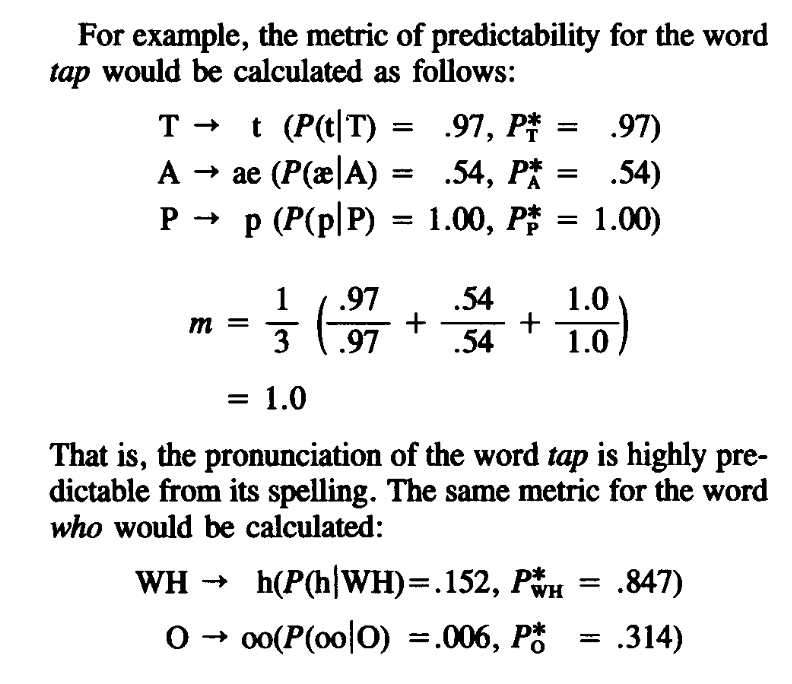
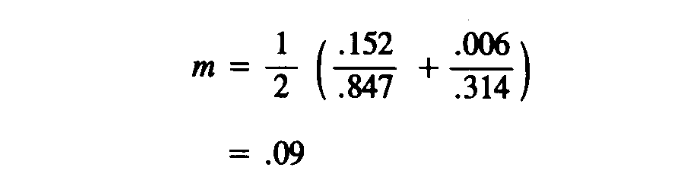

Would use the CMU dictionary mixed with the Berndt et al. data to accomplish this.


## The most up-to-date approach

In [4]:
import random
from collections import defaultdict
import re
import itertools
from icecream import ic
import numpy as np
from tqdm import tqdm
import json
import pickle
import pandas as pd
import spacy

In [34]:
# Helper function
def dict_print(target_dict, n=3):
    for key, value in list(target_dict.items())[:n]:
        ic(key, value)

## Setup

#### CMU dictionary setup

In [64]:
# Load CMU pronounciation dictionary from file
# This dictionary was created by Scott during the previous steps.
# I saved it into a pickle file so I won't have to re-run all the cells.
with open("pronounce_dic_tran.pkl", "rb") as f:
    pronounce_dic_tran = pickle.load(f)

# Create full cmu dictionary with the stresses removed
cmu_full = pronounce_dic_tran
cmu_full_nos = dict()
nums = [str(w) for w in range(10)]
for k, val in cmu_full.items():
    new_v = []
    for v in val:
        if v[-1] in nums:
            new_v.append(v[:-1])
        else:
            new_v.append(v)
    cmu_full_nos[k] = new_v
    
# Print out what the dictionary looks like
ic("This is with stress")
dict_print(pronounce_dic_tran)

# Print out what the cmu dictionary looks like with no stress
ic("This is without stress")
dict_print(cmu_full_nos)

ic| 'This is with stress'
ic| key: 'A', value: ['AH0']
ic| key: 'AS', value: ['EY1', 'Z']
ic| key: 'A42128'
    value: ['EY1', 'F', 'AO1', 'R', 'T', 'UW1', 'W', 'AH1', 'N', 'T', 'UW1', 'EY1', 'T']
ic| 'This is without stress'
ic| key: 'A', value: ['AH']
ic| key: 'AS', value: ['EY', 'Z']
ic| key: 'A42128'
    value: ['EY', 'F', 'AO', 'R', 'T', 'UW', 'W', 'AH', 'N', 'T', 'UW', 'EY', 'T']


#### Berndt dictionary setup

In [65]:
# Load csv with berndt consonants and vowels data merged into one
bdcp = pd.read_csv("berndt_data_with_cmu_phones_rerevised.csv", encoding='utf-8')

In [66]:
bdcp.head()

,Grapheme,Prior_prob,Phoneme,CMU_Phoneme,second CMU,Cond_prob,Example,Notes
0,A,0.0712,ae,AE1,NaN,0.542,cab,NaN
1,NaN,NaN,uh-,AH0,NaN,0.186,canal,NaN
2,NaN,NaN,ay,EY1,NaN,0.129,angel,NaN
3,NaN,NaN,ah,AA1,NaN,0.077,wad,NaN
4,NaN,NaN,aw,AO1,NaN,0.021,also,NaN


In [67]:
# Fill in grapheme column's empty (NaN) rows
prev = ""
new_graphemes = []

for grapheme in bdcp['Grapheme']:
    if not pd.isna(grapheme):
        prev = grapheme
    new_graphemes.append(prev)

bdcp['Grapheme'] = new_graphemes

In [68]:
bdcp.head()

,Grapheme,Prior_prob,Phoneme,CMU_Phoneme,second CMU,Cond_prob,Example,Notes
0,A,0.0712,ae,AE1,NaN,0.542,cab,NaN
1,A,NaN,uh-,AH0,NaN,0.186,canal,NaN
2,A,NaN,ay,EY1,NaN,0.129,angel,NaN
3,A,NaN,ah,AA1,NaN,0.077,wad,NaN
4,A,NaN,aw,AO1,NaN,0.021,also,NaN


In [69]:
# Create dictionary of phonemes and their conditional probability using Berndt's dictionary
phoneme_dict = defaultdict(dict)

nums = [str(w) for w in range(10)]

for phoneme, grapheme, prob in zip(bdcp['CMU_Phoneme'], bdcp['Grapheme'], bdcp['Cond_prob']):
    # Remove last character if it is a number (remove stress because they're not fully accounted for in CMU dict)
    if phoneme[-1] in nums:
        phoneme = phoneme[:-1]
    phoneme_dict[phoneme.upper()][grapheme.upper()] = prob

# create a copy of the phoneme dictionary for later use
phoneme_dict_copied = phoneme_dict.copy()

# Print what the dictionary looks like
dict_print(phoneme_dict, n=1)

ic| key: 'AE'
    value: {'A': 0.542,
            'A-E': 0.121,
            'AH': 1.0,
            'AI': 0.003,
            'AU': 0.025,
            'EA-E': 0.029,
            'Y': 0.002}


In [70]:
# -----------------
# Revise Berndt's dictionary by adding phoneme-grapheme pairs

def merge_nested_dicts(dict1, dict2):
    result = dict1.copy()
    for key, value in dict2.items():
        if key in result and isinstance(result[key], dict) and isinstance(value, dict):
            result[key] = merge_nested_dicts(result[key], value)
        else:
            result[key] = value
    return result

# Dictionary created to be added to the Berndt dictionary
# np.nan will not affect mean conditional probability 
# and it will help the alogirthm skip unprocessable (but legitimate) phoneme-grapheme pairs

# {Phoneme: {Grapheme: None}} # Example word
revdict = {'Y': {"J":np.nan}, # JANSKY
           'AW': {"AU":np.nan}, # AUGSBURGER
           'AA': {"AA":np.nan}, # AABERG
           'IY': {"Y":np.nan}, # ANYTHING
           'ER': {"ER":np.nan, "EAR":np.nan}, # AFTER, EARTH 
           'EH': {"UE":np.nan}, # GUESS
           'Z': {"X":np.nan}, # XANAX
           'ZH': {"X":np.nan, "J":np.nan}, # XIAO, JACQUES
          }

# Revised full phoneme dictionary with no stress
phoneme_dict = merge_nested_dicts(phoneme_dict, revdict)

#### Spacy setup

In [71]:
# Load from file
# This is all of the words in the CMU dict processed through the spacy pipeline
# This is used for lemma-related stuff but this doesn't affect the result at all
with open("spacy_dict.pkl", "rb") as f:
    spacy_dict = pickle.load(f)

# Print out what it looks like
dict_print(spacy_dict)

ic| key: 'A', value: A
ic| key: 'AS', value: AS
ic| key: 'A42128', value: A42128


#### Split CMU dictionary into root words v. others to process root words first

In [72]:
cmu_full_nos_roots = dict()
cmu_full_nos_remn = dict()

for k, v in cmu_full_nos.items():
    try:
        # This requires spacy_dict
        if spacy_dict[k][0].lemma_ == spacy_dict[k][0].text.lower():
            cmu_full_nos_roots[k] = v
        else:
            cmu_full_nos_remn[k] = v
    except:
        cmu_full_nos_remn[k] = v

### The Function

In [100]:
# Set this to true for verbose results
SET_LOG = False

# Printing for debugging using icecream library
def log_ic(val):
    if SET_LOG:
        ic(val)

# Main function
# Takes in word, phoneme, and whether the algorithm is going from front to back or from back to front
def phoneme_grapheme_match_lemma(word, phonemes, lemma_dict, front=True, second=True, uselemma=False):
    # Initialize variables to store results
    max_cond_probs = []
    min_word_remns = ""
    min_phonemes = []
    checkpoints = []
    prev_checkpoints = None
    consecutive_no_changes = 0
    original_word = word
    addon = []
    
    # Handle silent H at start of word
    if word[0] == "H" and phonemes[0] != "HH":
        original_word = word[1:]
    
    # Lemma-related features
    # This seems to hurt performance. Might need to revisit later. Turned off by default.
    # Switch uselemma=True in the argument to turn on
    if uselemma:
        # Check if the the current word contains a lemma that has already been processed
        try:
            word_lemma = spacy_dict[word][0].lemma_.upper()
        except:
            word_lemma = "NOT_FOUND"

        # If it does, use the existing processed information
        if word_lemma in lemma_dict:
            if lemma_dict[word_lemma][1] == phonemes[:len(lemma_dict[word_lemma][1])] and word_lemma == word[:len(word_lemma)]:
                original_word = word[len(word_lemma):]
                phonemes = phonemes[len(lemma_dict[word_lemma]):]
                addons = lemma_dict[word_lemma][0]

    # Loop while any grapheme is left unprocessed
    while word:
        
        # Reset grapheme list at the start of each loop
        word = original_word
        
        # List of conditional probabilities for current loop
        cond_probs = []
        
        # Checkpoints for current loop
        path = []
        
        # Iterate over phonemes
        for tier1_checkpoint, phoneme in enumerate(phonemes):
            # Hit will be set to True if a grapheme-phoneme pair is matched in a loop
            hit = False
            
            # Get all possible matching graphemes for the current phoneme
            targetdict = phoneme_dict[phoneme]
            
            # Start with longest grapheme
            targetdict_sorted = dict(sorted(targetdict.items(), key=lambda item: len(item[0]), reverse=True))
            
            for tier2_checkpoint, (grapheme_candidate, cond_prob) in enumerate(targetdict_sorted.items()):
                # use regex if necessary
                # for instances like "E-(1 or more consonants)-E" in "Edge"
                if "-" in grapheme_candidate:
                    # Only use this when processing from front to back
                    if front:
                        first, second = grapheme_candidate.split("-")
                        pattern = "^" + first + r"([^AEIOU]{1,2})" + second
                        fm = re.search(pattern, word)
                        if fm:
                            path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                            if path in checkpoints:
                                continue
                            # re-append the consonant part (e.g., 'dg' in 'Edge' after removing 'e-e')
                            word = fm.group(1) + word[len(fm[0]):]
                            # update conditional probability array for current main loop
                            cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                            if len(cond_probs) > len(max_cond_probs):
                                max_cond_probs = cond_probs.copy()
                                min_word_remns = word
                                min_phonemes = phonemes[tier1_checkpoint+1:]
                            hit = True
                            break
                    else:
                        pass
                # Check if there is a matching grapheme at the start of the word
                elif front and grapheme_candidate == word[:len(grapheme_candidate)]:
                    path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                    if path in checkpoints:
                        continue
                    word = word[len(grapheme_candidate):]
                    cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                    if len(cond_probs) > len(max_cond_probs):
                        max_cond_probs = cond_probs.copy()
                        min_word_remns = word
                        min_phonemes = phonemes[tier1_checkpoint+1:]
                    hit = True
                    break
                # Need different slicing when processing from back to front
                elif not front and grapheme_candidate == word[-len(grapheme_candidate):]:
                    path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                    if path in checkpoints:
                        continue
                    word = word[:-len(grapheme_candidate)]
                    cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                    if len(cond_probs) > len(max_cond_probs):
                        max_cond_probs = cond_probs.copy()
                        min_word_remns = word
                    hit = True
                    break
            # Keep track of bad paths so they're not visited again
            if not hit:
                if path != [] and path not in checkpoints:
                    checkpoints.append(path)
                break
        # Check if the current path has been explored
        if checkpoints != prev_checkpoints:
            prev_checkpoints = checkpoints.copy()  # Update the previous state
            consecutive_no_changes = 0  # Reset the counter
        # If current path has been explored previously, increment counter
        else:
            consecutive_no_changes += 1  # Increment the counter
        # If the list hasn't changed for two consecutive loops, break the loop
        if consecutive_no_changes == 2:
            if path[:-1] not in checkpoints:
                checkpoints.append(path[:-1])
        elif consecutive_no_changes >3:
            break
            
    # Re-run this function after from back to front with remaining phonemes if there are unprocessed graphemes
    if word and second and word != original_word and len(min_phonemes) != 0:
        mcp2, min_word_remns, lemma_dict = phoneme_grapheme_match_lemma(min_word_remns, min_phonemes, lemma_dict, front=False, second=False)
        max_cond_probs += mcp2
    
    # Clean-up and update lemma dictionary if all words have been processed, 
    if not word:
        min_word_remns = ""
        if uselemma and front and word_lemma == original_word:
            lemma_dict[original_word] = [max_cond_probs, phonemes]
    
    max_cond_probs += addon
    
    return max_cond_probs, min_word_remns, lemma_dict

def max_list(l1, l2):
    if len(l1) >= len(l2):
        return l1
    else:
        return l2

# function that does both front-back and back-front approach and returns the best result
def front_back_lemma(word, phonemes, lemma_dict):
    condprobs, word_remns, lemma_dict = phoneme_grapheme_match_lemma(word, phonemes, lemma_dict, front=True)
    if word_remns != []:
        back_condprobs, back_word_remns, lemma_dict = phoneme_grapheme_match_lemma(word, phonemes[::-1], lemma_dict, front=False)
        condprobs = max_list(condprobs, back_condprobs)
        word_remns = min(word_remns, back_word_remns)
    return condprobs, word_remns, lemma_dict

In [102]:
# Run the above for the full CMU items
# Initialize arrays for DF
wds = []
phnms = []
cond_probs_master = []
word_remns = []
proc_pers = []
cps = []
lemma_dict = dict()
SET_LOG = False

# Start with words where lemma=word
for word, phonemes in tqdm(cmu_full_nos_roots.items()):
    if word and phonemes:
        max_cond_probs, min_word_remns, lemma_dict = front_back_lemma(word, phonemes, lemma_dict)
        wds.append(word)
        phnms.append(phonemes)
        cond_probs_master.append(max_cond_probs)
        word_remns.append(len(phonemes)-len(max_cond_probs))
        proc_pers.append(len(max_cond_probs)/len(phonemes))
        if not max_cond_probs:
            cps.append(0)
        else:
            cps.append(np.mean([w[2] for w in max_cond_probs if not np.isnan(w[2])]))

# Do the rest
for word, phonemes in tqdm(cmu_full_nos_remn.items()):
    if word and phonemes:
        max_cond_probs, min_word_remns, lemma_dict = front_back_lemma(word, phonemes, lemma_dict)
        wds.append(word)
        phnms.append(phonemes)
        cond_probs_master.append(max_cond_probs)
        word_remns.append(len(phonemes)-len(max_cond_probs))
        proc_pers.append(len(max_cond_probs)/len(phonemes))
        if not max_cond_probs:
            cps.append(0)
        else:
            cps.append(np.mean([w[2] for w in max_cond_probs if not np.isnan(w[2])]))

100%|██████████| 89972/89972 [00:28<00:00, 3205.53it/s]


In [103]:
# Create dataframe
processed = pd.DataFrame({"Word":wds, 
             "Phonemes":phnms, 
             "Conditional Probablility":cond_probs_master,
             "Unprocessed phonemes":word_remns,
             "Processed percentage": proc_pers,
             "Conditional Probability Average": cps})

In [105]:
# Descriptive stats
processed.describe()

,Unprocessed phonemes,Processed percentage,Conditional Probability Average
count,121752.000000,121752.000000,121742.000000
mean,0.437348,0.937616,0.675740
std,1.173152,0.156018,0.142198
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.588105
50%,0.000000,1.000000,0.683000
75%,0.000000,1.000000,0.769833
max,19.000000,1.000000,1.000000


In [106]:
# First 50 rows
processed.head(50)

,Word,Phonemes,Conditional Probablility,Unprocessed phonemes,Processed percentage,Conditional Probability Average
0,A,[AH],"[[AH, A, 0.0005]]",0,1.000000,0.000500
1,AS,"[EY, Z]","[[EY, A, 0.129], [Z, S, 0.12]]",0,1.000000,0.124500
2,A42128,"[EY, F, AO, R, T, UW, W, AH, N, T, UW, EY, T]","[[EY, A, 0.129]]",12,0.076923,0.129000
3,AABERG,"[AA, B, ER, G]","[[AA, AA, nan], [B, B, 1.0], [ER, ER, nan], [G...",0,1.000000,0.820000
4,AACHEN,"[AA, K, AH, N]","[[N, N, 0.967], [AH, E, 0.096], [K, CH, 0.29],...",0,1.000000,0.451000
5,AAKER,"[AA, K, ER]","[[AA, AA, nan], [K, K, 1.0], [ER, ER, nan]]",0,1.000000,1.000000
6,AALSETH,"[AA, L, S, EH, TH]","[[AA, AA, nan], [L, L, 1.0], [S, S, 0.868], [E...",0,1.000000,0.754750
7,AAMODT,"[AA, M, AH, T]","[[AA, AA, nan], [M, M, 0.971], [AH, O, 0.002]]",1,0.750000,0.486500
8,AARDVARKS,"[AA, R, D, V, AA, R, K, S]","[[AA, AA, nan], [R, R, 1.0], [D, D, 0.991], [V...",0,1.000000,0.848000
9,ABACO,"[AE, B, AH, K, OW]","[[AE, A, 0.542], [B, B, 1.0], [AH, A, 0.0005],...",0,1.000000,0.522700


# Full Unorganized Notebook

In [1]:
import random
from collections import defaultdict
import re
import itertools
from icecream import ic
import numpy as np
from tqdm import tqdm
import json
import pickle
import pandas as pd

In [2]:
# Load from file
with open("pronounce_dic_tran.pkl", "rb") as f:
    pronounce_dic_tran = pickle.load(f)

In [ ]:
# csv with berndt consonants and vowels data merged into one
bdcp = pd.read_csv("berndt_data_with_cmu_phones_rerevised.csv", encoding='utf-8')

In [4]:
bdcp.head()

,Grapheme,Prior_prob,Phoneme,CMU_Phoneme,second CMU,Cond_prob,Example,Notes
0,A,0.0712,ae,AE1,NaN,0.542,cab,NaN
1,NaN,NaN,uh-,AH0,NaN,0.186,canal,NaN
2,NaN,NaN,ay,EY1,NaN,0.129,angel,NaN
3,NaN,NaN,ah,AA1,NaN,0.077,wad,NaN
4,NaN,NaN,aw,AO1,NaN,0.021,also,NaN


In [5]:
# sample 10 items from CMU dict for illustrative purposes
# requires `pronounce_dic_tran` to be declared from the cells above
random.seed(42)
random_numbers = random.sample(range(0, len(pronounce_dic_tran)), 10)
cmu_sample = {list(pronounce_dic_tran.keys())[i]:list(pronounce_dic_tran.values())[i] for i in random_numbers}

In [6]:
# this is what the sampled items look like
cmu_sample

{'PISSING': ['P', 'IH1', 'S', 'IH2', 'NG'],
 'BUGBEE': ['B', 'AH1', 'G', 'B', 'IY2'],
 'AMOCO': ['AE1', 'M', 'AH0', 'K', 'OW0'],
 'SCUTTLEBUTT': ['S', 'K', 'AH1', 'T', 'AH0', 'L', 'B', 'AH2', 'T'],
 'EXTRACTION': ['EH0', 'K', 'S', 'T', 'R', 'AE1', 'K', 'SH', 'AH0', 'N'],
 'E': ['IY1'],
 'DISAPPEAR': ['D', 'IH2', 'S', 'AH0', 'P', 'IH1', 'R'],
 'CHARALAMBOS': ['CH', 'AA2', 'R', 'AH0', 'L', 'AA1', 'M', 'B', 'OW0', 'S'],
 'SCHOOLGIRL': ['S', 'K', 'UW1', 'L', 'G', 'ER2', 'L'],
 'BRESCA': ['B', 'R', 'EH1', 'S', 'K', 'AH0']}

In [7]:
# Fill in grapheme column's empty rows
prev = ""
new_graphemes = []

for grapheme in bdcp['Grapheme']:
    if not pd.isna(grapheme):
        prev = grapheme
    new_graphemes.append(prev)

bdcp['Grapheme'] = new_graphemes

In [8]:
# Empty spaces in Grapheme column has been filled
bdcp.head()

,Grapheme,Prior_prob,Phoneme,CMU_Phoneme,second CMU,Cond_prob,Example,Notes
0,A,0.0712,ae,AE1,NaN,0.542,cab,NaN
1,A,NaN,uh-,AH0,NaN,0.186,canal,NaN
2,A,NaN,ay,EY1,NaN,0.129,angel,NaN
3,A,NaN,ah,AA1,NaN,0.077,wad,NaN
4,A,NaN,aw,AO1,NaN,0.021,also,NaN


In [9]:
# Create dictionary of phonemes and their conditional probability using Berndt's dictionary
phoneme_dict = defaultdict(dict)

for phoneme, grapheme, prob in zip(bdcp['CMU_Phoneme'], bdcp['Grapheme'], bdcp['Cond_prob']):
    phoneme_dict[phoneme.upper()][grapheme.upper()] = prob

In [10]:
# For illustration purposes, grapheme dictionary would look like this:
grapheme_dict = defaultdict(dict)

for phoneme, grapheme, prob in zip(bdcp['CMU_Phoneme'], bdcp['Grapheme'], bdcp['Cond_prob']):
    grapheme_dict[grapheme.upper()][phoneme.upper()] = prob

In [11]:
# Phoneme dict structure and explanation
for i, (k, v) in enumerate(phoneme_dict.items()):
    print(f"The phoneme <{k}> can appear as the following graphemes {v}")
    if i == 4:
        break

The phoneme <AE1> can appear as the following graphemes {'A': 0.542, 'A-E': 0.121, 'AH': 1.0, 'AI': 0.003, 'AU': 0.025, 'Y': 0.002}
The phoneme <AH0> can appear as the following graphemes {'A': 0.0005, 'A-E': 0.002, 'AI': 0.031, 'E': 0.096, 'E-E': 0.286, 'EA': 0.005, 'EI': 0.035, 'EO': 0.666, 'EOU': 1.0, 'ET': 1.0, 'I': 0.18, 'I-E': 0.006, 'IA': 1.0, 'IE': 0.101, 'IE-E': 0.129, 'O': 0.269, 'O-E': 0.044, 'OI-E': 0.2, 'OU': 0.48, 'U': 0.102, 'U-E': 0.01, 'Y': 0.01, 'AL': 1.0, 'EL': 1.0, 'EN': 1.0, 'IL': 1.0, 'IN': 1.0, 'LE': 1.0, 'M': 0.028, 'OL': 1.0, 'ON': 1.0}
The phoneme <EY1> can appear as the following graphemes {'A': 0.129, 'A-E': 0.651, 'AI': 0.734, 'AI-E': 0.818, 'AIGH': 1.0, 'AU-E': 0.083, 'AY': 0.97, 'E': 0.002, 'E-E': 0.017, 'EA': 0.027, 'EI': 0.245, 'EI-E': 0.25, 'EIGH': 0.857, 'EY': 0.225, 'Y': 0.002}
The phoneme <AA1> can appear as the following graphemes {'A': 0.077, 'A-E': 0.025, 'AU': 0.006, 'AU-E': 0.75, 'AUGH': 1.0, 'AW-E': 1.0, 'E': 0.0006, 'EA': 0.035, 'O': 0.261, '

In [12]:
# Phoneme dict structure and explanation
for i, (k, v) in enumerate(grapheme_dict.items()):
    print(f"The grapheme <{k}> can appear as the following phonemes {v}")
    if i == 4:
        break

The grapheme <A> can appear as the following phonemes {'AE1': 0.542, 'AH0': 0.0005, 'EY1': 0.129, 'AA1': 0.077, 'AO1': 0.021, 'ER0': 0.021, 'EH1': 0.02}
The grapheme <A-E> can appear as the following phonemes {'EY1': 0.651, 'IH0': 0.154, 'AE1': 0.121, 'AH0': 0.002, 'AA1': 0.025, 'AO1': 0.002}
The grapheme <AE> can appear as the following phonemes {'IY0': 0.833, 'EH0': 0.166}
The grapheme <AH> can appear as the following phonemes {'AE1': 1.0}
The grapheme <AI> can appear as the following phonemes {'EY1': 0.734, 'EH1': 0.176, 'AH0': 0.031, 'AE1': 0.003}


## Approach 1: transform phonemes to possible graphemes and match with the target word's graphemes

In [29]:
# cond_probs_master = []
# word_remn = []

# # iterate over items in CMU dict
# for word, phonemes in cmu_sample.items():
#     max_condprobs = []
#     min_word_remns = []
#     checkpoints = []
#     prev_checkpoints = None
#     consecutive_no_changes = 0
#     print(f"Start with word: {word}")
#     original_word = word
#     while word:
#         word = original_word
#         print(word)
#         cond_probs = []
#         path = []
#         # iterate over phonemes
#         # use checkpoints
#         for tier1_checkpoint, phoneme in enumerate(phonemes):
#             hit = False
#             # check if there is a grapheme match
#             targetdict = phoneme_dict[phoneme]
#             # start with longest grapheme
#             targetdict_sorted = dict(sorted(targetdict.items(), key=lambda item: len(item[0]), reverse=True))
#             for tier2_checkpoint, (grapheme_candidate, cond_prob) in enumerate(targetdict_sorted.items()):
#                 # invoke regex if necessary
#                 if "-" in grapheme_candidate:
#                     first, second = grapheme_candidate.split("-")
#                     pattern = "^" + first + r"[^AEIOU]{1,2}" + second
#                     fm = re.search(pattern, word)
#                     if fm:
#                         path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
#                         if path in checkpoints:
#                             continue
#                         word = word[len(fm[0]):]
#                         cond_probs.append([phoneme, grapheme_candidate, cond_prob])
#                         if len(cond_probs) > len(max_condprobs):
#                             max_cond_probs = cond_probs
#                             min_word_remns = [word]
#                         hit = True
#                         break
#                 # 
#                 elif grapheme_candidate == word[:len(grapheme_candidate)]:
#                     path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
#                     if path in checkpoints:
#                         continue
#                     word = word[len(grapheme_candidate):]
#                     cond_probs.append([phoneme, grapheme_candidate, cond_prob])
#                     if len(cond_probs) > len(max_condprobs):
#                         max_cond_probs = cond_probs
#                         min_word_remns = [word]
#                     hit = True
#                     break
#             if not hit:
#                 if path != [] and path not in checkpoints:
#                     checkpoints.append(path)
#                 break
#         if checkpoints != prev_checkpoints:
#             prev_checkpoints = checkpoints.copy()  # Update the previous state
#             consecutive_no_changes = 0  # Reset the counter
#         else:
#             consecutive_no_changes += 1  # Increment the counter

#         # If the list hasn't changed for two consecutive loops, break the loop
#         if consecutive_no_changes >= 2:
#             break
#     cond_probs_master.append(max_cond_probs)
#     word_remn.append(min_word_remns)

In [30]:
# Look at the sample words
cmu_sample

{'PISSING': ['P', 'IH1', 'S', 'IH2', 'NG'],
 'BUGBEE': ['B', 'AH1', 'G', 'B', 'IY2'],
 'AMOCO': ['AE1', 'M', 'AH0', 'K', 'OW0'],
 'SCUTTLEBUTT': ['S', 'K', 'AH1', 'T', 'AH0', 'L', 'B', 'AH2', 'T'],
 'EXTRACTION': ['EH0', 'K', 'S', 'T', 'R', 'AE1', 'K', 'SH', 'AH0', 'N'],
 'E': ['IY1'],
 'DISAPPEAR': ['D', 'IH2', 'S', 'AH0', 'P', 'IH1', 'R'],
 'CHARALAMBOS': ['CH', 'AA2', 'R', 'AH0', 'L', 'AA1', 'M', 'B', 'OW0', 'S'],
 'SCHOOLGIRL': ['S', 'K', 'UW1', 'L', 'G', 'ER2', 'L'],
 'BRESCA': ['B', 'R', 'EH1', 'S', 'K', 'AH0']}

In [32]:
# Look at remaining parts of words that the algorithm were unable to process
# word_remn

### Problem

'PISSING': ['P', 'IH1', 'S', 'IH2', 'NG']
=> 'IH1' has no grapheme "I"

'DISAPPEAR': ['D', 'IH2', 'S', 'AH0', 'P', 'IH1', 'R']
=> 'IH2' only can be represented as grapheme 'Y-E'

'CHARALAMBOS': ['CH', 'AA2', 'R', 'AH0', 'L', 'AA1', 'M', 'B', 'OW0', 'S'],
=> No such thing as 'AA2' in Berndt

'BUGBEE': ['B', 'AH1', 'G', 'B', 'IY2'],
=> BEE is 'B' + 'IY1' in Berndt

Solution is => Get rid of numbers behind phonemes since they're about stress and we only care about phonemes anyway

## Approach 2: Remove numbers from phonemes since IH1 and IH2 are the same phoneme anyway

In [13]:
# sample 10 items from CMU dict for illustrative purposes
random.seed(42)
random_numbers = random.sample(range(0, len(pronounce_dic_tran)), 1000)
cmu_sample = {list(pronounce_dic_tran.keys())[i]:list(pronounce_dic_tran.values())[i] for i in random_numbers}
cmu_sample_nos = dict()
nums = [str(w) for w in range(10)]
for k, val in cmu_sample.items():
    new_v = []
    for v in val:
        if v[-1] in nums:
            new_v.append(v[:-1])
        else:
            new_v.append(v)
    cmu_sample_nos[k] = new_v

In [14]:
phoneme_dict = defaultdict(dict)

for phoneme, grapheme, prob in zip(bdcp['CMU_Phoneme'], bdcp['Grapheme'], bdcp['Cond_prob']):
    if phoneme[-1] in nums:
        phoneme = phoneme[:-1]
    phoneme_dict[phoneme.upper()][grapheme.upper()] = prob

# create a copy of the phoneme dictionary for later use
phoneme_dict_copied = phoneme_dict.copy()

In [15]:
# How to handle H exceptions
for k, v in phoneme_dict.items():
    for k2, v2, in v.items():
        if k2 == "H":
            print(k, v)

HH {'H': 1.0, 'WH': 0.152}


In [142]:
# Set this to true for verbose results
SET_LOG = False

# Printing for debugging using icecream library
def log_ic(val):
    if SET_LOG:
        ic(val)

# Main function
# Takes in word, phoneme, and whether the algorithm is going from front to back or from back to front
def phoneme_grapheme_match(word, phonemes, front=True):
    max_cond_probs = []
    min_word_remns = []
    checkpoints = []
    prev_checkpoints = None
    consecutive_no_changes = 0
    original_word = word
    
    # Handle silent H at start of word
    if word[0] == "H" and phonemes[0] != "HH":
        original_word = word[1:]
        
    while word:
        log_ic(word)
        word = original_word
        cond_probs = []
        path = []
        # iterate over phonemes
        # use checkpoints
        for tier1_checkpoint, phoneme in enumerate(phonemes):
            hit = False
            # check if there is a grapheme match
            targetdict = phoneme_dict[phoneme]
            # start with longest grapheme
            targetdict_sorted = dict(sorted(targetdict.items(), key=lambda item: len(item[0]), reverse=True))
            for tier2_checkpoint, (grapheme_candidate, cond_prob) in enumerate(targetdict_sorted.items()):
                # invoke regex if necessary
                # for instances like "Edge"
                if "-" in grapheme_candidate:
                    if front:
                        first, second = grapheme_candidate.split("-")
                        pattern = "^" + first + r"([^AEIOU]{1,2})" + second
                        fm = re.search(pattern, word)
                        if fm:
                            path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                            if path in checkpoints:
                                continue
                            # re-append the consonant part (e.g., 'dg' in 'Edge' after removing 'e-e')
                            word = fm.group(1) + word[len(fm[0]):]
                            cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                            if len(cond_probs) > len(max_cond_probs):
                                max_cond_probs = cond_probs
                                min_word_remns = [word]
                            hit = True
                            log_ic(word)
                            break
                    else:
                        pass
                elif front and grapheme_candidate == word[:len(grapheme_candidate)]:
                    path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                    if path in checkpoints:
                        continue
                    word = word[len(grapheme_candidate):]
                    cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                    if len(cond_probs) > len(max_cond_probs):
                        max_cond_probs = cond_probs
                        min_word_remns = [word]
                    hit = True
                    log_ic(word)
                    break
                elif not front and grapheme_candidate == word[-len(grapheme_candidate):]:
                    path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                    if path in checkpoints:
                        continue
                    word = word[:-len(grapheme_candidate)]
                    cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                    if len(cond_probs) > len(max_cond_probs):
                        max_cond_probs = cond_probs
                        min_word_remns = [word]
                    hit = True
                    log_ic(word)
                    break
            if not hit:
                if path != [] and path not in checkpoints:
                    checkpoints.append(path)
                    log_ic(path)
                    log_ic(checkpoints)
                break
        if checkpoints != prev_checkpoints:
            prev_checkpoints = checkpoints.copy()  # Update the previous state
            consecutive_no_changes = 0  # Reset the counter
        else:
            consecutive_no_changes += 1  # Increment the counter
        # If the list hasn't changed for two consecutive loops, break the loop
        if consecutive_no_changes == 2:
            if path[:-1] not in checkpoints:
                checkpoints.append(path[:-1])
        elif consecutive_no_changes >3:
            break
    if not word:
        min_word_remns = []
        
    return max_cond_probs, min_word_remns

def max_list(l1, l2):
    if len(l1) >= len(l2):
        return l1
    else:
        return l2

In [143]:
# function that does both front-back and back-front approach and returns the best result
def front_back(word, phonemes):
    condprobs, word_remns = phoneme_grapheme_match(word, phonemes, front=True)
    if word_remns != []:
        back_condprobs, back_word_remns = phoneme_grapheme_match(word, phonemes[::-1], front=False)
        condprobs = max_list(condprobs, back_condprobs)
        word_remns = min(word_remns, back_word_remns)
    return condprobs, word_remns

In [145]:
# Run the above for the 1,000 CMU samples
wds = []
phnms = []
cond_probs_master = []
word_remns = []
proc_pers = []
SET_LOG = False

for word, phonemes in tqdm(cmu_full_nos.items()):
    if word != "":
        max_cond_probs, min_word_remns = front_back(word, phonemes)
        wds.append(word)
        phnms.append(phonemes)
        cond_probs_master.append(max_cond_probs)
        word_remns.append(len(phonemes)-len(max_cond_probs))
        proc_pers.append(len(max_cond_probs)/len(phonemes))

100%|██████████| 121753/121753 [00:23<00:00, 5175.05it/s]


In [146]:
processed = pd.DataFrame({"Word":wds, 
             "Phonemes":phnms, 
             "Conditional Probablility":cond_probs_master,
             "Unprocessed graphemes":word_remns,
             "Processed percentage": proc_pers})

In [147]:
# Look at results
processed

,Word,Phonemes,Conditional Probablility,Unprocessed graphemes,Processed percentage
0,A,[AH],"[[AH, A, 0.0005]]",0,1.000000
1,AS,"[EY, Z]","[[EY, A, 0.129], [Z, S, 0.12]]",0,1.000000
2,A42128,"[EY, F, AO, R, T, UW, W, AH, N, T, UW, EY, T]","[[EY, A, 0.129]]",12,0.076923
3,AA,"[EY, EY]","[[EY, A, 0.129], [EY, A, 0.129]]",0,1.000000
4,AAA,"[T, R, IH, P, AH, L, EY]",[],7,0.000000
...,...,...,...,...,...
121747,ZYSK,"[Z, IH, S, K]","[[Z, Z, 0.996], [IH, Y, 0.073], [S, S, 0.868],...",0,1.000000
121748,ZYSKOWSKI,"[Z, IH, S, K, AO, F, S, K, IY]","[[Z, Z, 0.996], [IH, Y, 0.073], [S, S, 0.868],...",4,0.555556
121749,ZYUGANOV,"[Z, Y, UW, G, AA, N, AA, V]","[[Z, Z, 0.996], [Y, Y, 0.025], [UW, U, 0.032],...",0,1.000000
121750,ZYUGANOVS,"[Z, Y, UW, G, AA, N, AA, V, Z]","[[Z, Z, 0.996], [Y, Y, 0.025], [UW, U, 0.032],...",0,1.000000


In [148]:
# Take a look at how much was processed
processed['Processed percentage'].describe()

count    121752.000000
mean          0.878948
std           0.200422
min           0.000000
25%           0.800000
50%           1.000000
75%           1.000000
max           1.000000
Name: Processed percentage, dtype: float64

In [49]:
'''

Problematic items

'SCHOOLGIRL': ['S', 'K', 'UW', 'L', 'G', 'ER', 'L']
=> CMU's 'ER'

{'A': 0.021,
 'E': 0.249,
 'E-E': 0.119,
 'EA': 0.056,
 'EA-E': 0.058,
 'EU': 0.153,
 'I': 0.015,
 'I-E': 0.001,
 'O': 0.053,
 'O-E': 0.002,
 'OU': 0.031,
 'OU-E': 0.014,
 'U': 0.08,
 'U-E': 0.09}


 'DISAPPEAR': ['D', 'IH', 'S', 'AH', 'P', 'IH', 'R'],
 => CMU's P
 {'P': 1.0}
 
 
'''

"\n\nProblematic items\n\n'SCHOOLGIRL': ['S', 'K', 'UW', 'L', 'G', 'ER', 'L']\n=> CMU's 'ER'\n\n{'A': 0.021,\n 'E': 0.249,\n 'E-E': 0.119,\n 'EA': 0.056,\n 'EA-E': 0.058,\n 'EU': 0.153,\n 'I': 0.015,\n 'I-E': 0.001,\n 'O': 0.053,\n 'O-E': 0.002,\n 'OU': 0.031,\n 'OU-E': 0.014,\n 'U': 0.08,\n 'U-E': 0.09}\n\n\n 'DISAPPEAR': ['D', 'IH', 'S', 'AH', 'P', 'IH', 'R'],\n => CMU's P\n {'P': 1.0}\n \n \n"

In [50]:
'''
?Solution

Human in the loop trial and error?

Add {'PP': None}
'''

"\n?Solution\n\nHuman in the loop trial and error?\n\nAdd {'PP': None}\n"

In [51]:
# Take a look at the most problematic items
processed[processed['Processed percentage']==0]

,Word,Phonemes,Conditional Probablility,Unprocessed graphemes,Processed percentage
906,WEISZ,"[V, AY, SH]",[],3,0.0
940,LS,"[EH, L, Z]",[],3,0.0


## Modification 1
### Add null items

In [16]:
def merge_nested_dicts(dict1, dict2):
    result = dict1.copy()
    for key, value in dict2.items():
        if key in result and isinstance(result[key], dict) and isinstance(value, dict):
            result[key] = merge_nested_dicts(result[key], value)
        else:
            result[key] = value
    return result

In [181]:
# Dictionary created to be added to the Berndt dictionary
# np.nan will not affect means

# {Phoneme: {Grapheme: None}} # Example word
revdict = {'Y': {"J":np.nan}, # JANSKY
           'AW': {"AU":np.nan}, # AUGSBURGER
           'AA': {"AA":np.nan}, # AABERG
           'IY': {"Y":np.nan}, # ANYTHING
           'ER': {"ER":np.nan, # AFTER
           		  "EAR":np.nan}, # EARTH
           'EH': {"UE":np.nan}, # GUESS
           'Z': {"X":np.nan}, # XANAX
           'ZH': {"X":np.nan, "J":np.nan}, # XIAO, JACQUES
          }

In [182]:
# Illustration of how np.nan will not affect means and other stats
pd.Series([1, 1, np.nan]).describe()

count    2.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
dtype: float64

In [183]:
# Reset phoneme dict if needed
phoneme_dict = phoneme_dict_copied

In [184]:
# Merge phoneme dict with the new dictionary above
phoneme_dict = merge_nested_dicts(phoneme_dict, revdict)

In [21]:
# Rerun with the new dictinoary
wds = []
phnms = []
cond_probs_master = []
word_remns = []
proc_pers = []
SET_LOG = False

for word, phonemes in cmu_sample_nos.items():
    max_cond_probs, min_word_remns = front_back(word, phonemes)
    wds.append(word)
    phnms.append(phonemes)
    cond_probs_master.append(max_cond_probs)
    word_remns.append(len(phonemes)-len(max_cond_probs))
    proc_pers.append(len(max_cond_probs)/len(phonemes))

NameError: name 'front_back' is not defined

In [72]:
processed = pd.DataFrame({"Word":wds, 
             "Phonemes":phnms, 
             "Conditional Probablility":cond_probs_master,
             "Unprocessed graphemes":word_remns,
             "Processed percentage": proc_pers})

In [73]:
processed

,Word,Phonemes,Conditional Probablility,Unprocessed graphemes,Processed percentage
0,PISSING,"[P, IH, S, IH, NG]","[[P, P, 1.0], [IH, I, 0.716], [S, SS, 0.952], ...",0,1.000000
1,BUGBEE,"[B, AH, G, B, IY]","[[B, B, 1.0], [AH, U-E, 0.01], [G, G, 0.64], [...",0,1.000000
2,AMOCO,"[AE, M, AH, K, OW]","[[AE, A, 0.542], [M, M, 0.971], [AH, O, 0.002]...",0,1.000000
3,SCUTTLEBUTT,"[S, K, AH, T, AH, L, B, AH, T]","[[S, S, 0.868], [K, C, 0.757], [AH, U, 0.102],...",4,0.555556
4,EXTRACTION,"[EH, K, S, T, R, AE, K, SH, AH, N]","[[N, ON, 1.0], [AH, I, 0.18], [SH, T, 0.003], ...",3,0.700000
...,...,...,...,...,...
995,SENNE,"[S, EH, N]","[[S, S, 0.868], [EH, E-E, 0.321], [N, NN, 1.0]]",0,1.000000
996,RUPIAH,"[R, UW, P, AY, AH]","[[R, R, 1.0], [UW, U, 0.032], [P, P, 1.0], [AY...",0,1.000000
997,BURKETT,"[B, ER, K, IH, T]","[[T, TT, 1.0], [IH, E, 0.0006], [K, K, 1.0]]",2,0.600000
998,SOLAN,"[S, OW, L, AH, N]","[[S, S, 0.868], [OW, O, 0.314], [L, L, 1.0], [...",0,1.000000


In [149]:
# Take a look at how much was improved
# New mean is slightly better than 0.847619
processed.describe()

,Unprocessed graphemes,Processed percentage
count,121752.000000,121752.000000
mean,0.835543,0.878948
std,1.522760,0.200422
min,0.000000,0.000000
25%,0.000000,0.800000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,22.000000,1.000000


In [61]:
# Look at problematic words
processed[processed['Processed percentage']<0.7]

,Word,Phonemes,Conditional Probablility,Unprocessed graphemes,Processed percentage
3,SCUTTLEBUTT,"[S, K, AH, T, AH, L, B, AH, T]","[[S, S, 0.868], [K, C, 0.757], [AH, U, 0.102],...",4,0.555556
15,NUZZLES,"[N, AH, Z, AH, L, Z]","[[N, N, 0.967], [AH, U, 0.102], [Z, ZZ, 1.0], ...",2,0.666667
60,ATAXIAS,"[EY, T, AE, K, S, IY, AH, Z]","[[EY, A, 0.129], [T, T, 0.973], [AE, A, 0.542]]",5,0.375000
62,KUHNLE,"[K, AH, N, AH, L]","[[K, K, 1.0], [AH, U, 0.102]]",3,0.400000
70,TENURED,"[T, EH, N, Y, ER, D]","[[T, T, 0.973], [EH, E, 0.419], [N, N, 0.967]]",3,0.500000
...,...,...,...,...,...
970,POWERFUL,"[P, AW, ER, F, AH, L]","[[P, P, 1.0], [AW, OW, 0.481], [ER, E, 0.249]]",3,0.500000
975,DEARY,"[D, IH, R, IY]","[[D, D, 0.991], [IH, E, 0.0006]]",2,0.500000
984,BURHAM,"[B, ER, HH, AH, M]","[[M, M, 0.971], [AH, A, 0.0005], [HH, H, 1.0]]",2,0.600000
994,OVERACTS,"[OW, V, ER, AE, K, T, S]","[[S, S, 0.868], [T, T, 0.973], [K, C, 0.757], ...",3,0.571429


In [75]:
[1,2,3][:2]

[1, 2]

## Sandbox for adding null items

In [22]:
# Use this part to take a look at how the algorithm performs on individual words
DISPLAYWORD = "M"

wds = []
phnms = []
cond_probs_master = []
word_remns = []
SET_LOG = True

for word, phonemes in cmu_sample_nos.items():
    if word == DISPLAYWORD:
        max_cond_probs, min_word_remns = phoneme_grapheme_match(word, phonemes)
        wds.append(word)
        phnms.append(phonemes)
        cond_probs_master.append(max_cond_probs)
        word_remns.append(min_word_remns)

1) 
GET to the lemma first
Lemma = Board
Process the difference between the lemma and token first, then process the lemma
If lemma exists in CMU, use that (caching)

2) 
Third loop where only remaining parts are processed backwards

3)
If failure, try starting from second phoneme

In [75]:
pronounce_dic_tran['ONE']

['W', 'AH1', 'N']

In [76]:
pronounce_dic_tran['ONE']

['W', 'AH1', 'N']

In [77]:
phoneme_dict['N']

{'EN': 1.0,
 'GN': 1.0,
 'IN': 1.0,
 'KN': 1.0,
 'MN': 0.125,
 'N': 0.967,
 'NN': 1.0,
 'ON': 1.0,
 'PN': 1.0}

In [66]:
for k, v in phoneme_dict.items():
    if 'O' in list(v.keys()):
        print(k)

AH
AA
AO
ER
IH
OW
UW


In [67]:
processed[processed['Word'] == "board"]['Conditional Probablility'].values

array([], dtype=object)

## Additional steps

In [23]:
import spacy

In [24]:
nlp = spacy.load("en_core_web_sm")

In [49]:
# Set this to true for verbose results
SET_LOG = False

# Printing for debugging using icecream library
def log_ic(val):
    if SET_LOG:
        ic(val)

# Main function
# Takes in word, phoneme, and whether the algorithm is going from front to back or from back to front
def phoneme_grapheme_match_lemma(word, phonemes, lemma_dict, front=True, second=True):
    max_cond_probs = []
    min_word_remns = ""
    min_phonemes = []
    checkpoints = []
    prev_checkpoints = None
    consecutive_no_changes = 0
    original_word = word
    
    # Handle silent H at start of word
    if word[0] == "H" and phonemes[0] != "HH":
        original_word = word[1:]
    try:
        word_lemma = spacy_dict[word][0].lemma_.upper()
    except:
        word_lemma = "NOT_FOUND"
    if word_lemma in lemma_dict:
        if lemma_dict[word_lemma] == phonemes[:len(lemma_dict[word_lemma])] and lemma == word[:len(lemma)]:
            word = word[len("lemma"):]
            phonemes = phonemes[len(lemma_dict[word_lemma]):]

    while word:
        word = original_word
        cond_probs = []
        path = []
        # iterate over phonemes
        # use checkpoints
        for tier1_checkpoint, phoneme in enumerate(phonemes):
            # keep track of any new information
            hit = False
            # check if there is a grapheme match
            targetdict = phoneme_dict[phoneme]
            # start with longest grapheme
            targetdict_sorted = dict(sorted(targetdict.items(), key=lambda item: len(item[0]), reverse=True))
            for tier2_checkpoint, (grapheme_candidate, cond_prob) in enumerate(targetdict_sorted.items()):
                # invoke regex if necessary
                # for instances like "Edge"
                if "-" in grapheme_candidate:
                    if front:
                        first, second = grapheme_candidate.split("-")
                        pattern = "^" + first + r"([^AEIOU]{1,2})" + second
                        fm = re.search(pattern, word)
                        if fm:
                            path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                            if path in checkpoints:
                                continue
                            # re-append the consonant part (e.g., 'dg' in 'Edge' after removing 'e-e')
                            word = fm.group(1) + word[len(fm[0]):]
                            cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                            if len(cond_probs) > len(max_cond_probs):
                                max_cond_probs = cond_probs.copy()
                                min_word_remns = word
                                min_phonemes = phonemes[tier1_checkpoint+1:]
                            hit = True
                            break
                    else:
                        pass
                elif front and grapheme_candidate == word[:len(grapheme_candidate)]:
                    path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                    if path in checkpoints:
                        continue
                    word = word[len(grapheme_candidate):]
                    cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                    if len(cond_probs) > len(max_cond_probs):
                        max_cond_probs = cond_probs.copy()
                        min_word_remns = word
                        min_phonemes = phonemes[tier1_checkpoint+1:]
                    hit = True
                    break
                elif not front and grapheme_candidate == word[-len(grapheme_candidate):]:
                    path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                    if path in checkpoints:
                        continue
                    word = word[:-len(grapheme_candidate)]
                    cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                    if len(cond_probs) > len(max_cond_probs):
                        max_cond_probs = cond_probs.copy()
                        min_word_remns = word
                    hit = True
                    break
            # Keep track of bad paths so they're not visited again
            if not hit:
                if path != [] and path not in checkpoints:
                    checkpoints.append(path)
                break
        # If stuck in a loop
        if checkpoints != prev_checkpoints:
            prev_checkpoints = checkpoints.copy()  # Update the previous state
            consecutive_no_changes = 0  # Reset the counter
        else:
            consecutive_no_changes += 1  # Increment the counter
        # If the list hasn't changed for two consecutive loops, break the loop
        if consecutive_no_changes == 2:
            if path[:-1] not in checkpoints:
                checkpoints.append(path[:-1])
        elif consecutive_no_changes >3:
            break
    if word and second and word != original_word and len(min_phonemes) != 0:
        log_ic("Running it back")
        log_ic(min_word_remns[0])
        log_ic(min_word_remns)
        log_ic(min_phonemes)
        mcp2, min_word_remns, lemma_dict = phoneme_grapheme_match_lemma(min_word_remns, min_phonemes, lemma_dict, front=False, second=False)
        max_cond_probs += mcp2
    if not word:
        min_word_remns = ""
        if front and word_lemma == original_word:
            lemma_dict[original_word] = word_lemma
        
    return max_cond_probs, min_word_remns, lemma_dict

def max_list(l1, l2):
    if len(l1) >= len(l2):
        return l1
    else:
        return l2

In [50]:
# function that does both front-back and back-front approach and returns the best result
def front_back_lemma(word, phonemes, lemma_dict):
    condprobs, word_remns, lemma_dict = phoneme_grapheme_match_lemma(word, phonemes, lemma_dict, front=True)
    if word_remns != []:
        back_condprobs, back_word_remns, lemma_dict = phoneme_grapheme_match_lemma(word, phonemes[::-1], lemma_dict, front=False)
        condprobs = max_list(condprobs, back_condprobs)
        word_remns = min(word_remns, back_word_remns)
    return condprobs, word_remns, lemma_dict

In [51]:
SET_LOG = True
mcp, mwr, ld = front_back_lemma("PHISHING", cmu_full_nos["PHISHING"], lemma_dict)

In [ ]:
SET_LOG = True
mcp, mwr, ld = front_back_lemma("PHISHING", cmu_full_nos["PHISHING"], lemma_dict)

In [217]:
# Run the above for the 1,000 CMU samples
wds = []
phnms = []
cond_probs_master = []
word_remns = []
proc_pers = []
lemma_dict = dict()
SET_LOG = False

for word, phonemes in cmu_sample_nos.items():
    max_cond_probs, min_word_remns, lemma_dict = front_back_lemma(word, phonemes, lemma_dict)
    wds.append(word)
    phnms.append(phonemes)
    cond_probs_master.append(max_cond_probs)
    word_remns.append(len(phonemes)-len(max_cond_probs))
    proc_pers.append(len(max_cond_probs)/len(phonemes))

In [119]:
processed = pd.DataFrame({"Word":wds, 
             "Phonemes":phnms, 
             "Conditional Probablility":cond_probs_master,
             "Unprocessed graphemes":word_remns,
             "Processed percentage": proc_pers})

In [120]:
processed

,Word,Phonemes,Conditional Probablility,Unprocessed graphemes,Processed percentage
0,PISSING,"[P, IH, S, IH, NG]","[[P, P, 1.0], [IH, I, 0.716], [S, SS, 0.952], ...",0,1.000000
1,BUGBEE,"[B, AH, G, B, IY]","[[B, B, 1.0], [AH, U-E, 0.01], [G, G, 0.64], [...",0,1.000000
2,AMOCO,"[AE, M, AH, K, OW]","[[AE, A, 0.542], [M, M, 0.971], [AH, O, 0.002]...",0,1.000000
3,SCUTTLEBUTT,"[S, K, AH, T, AH, L, B, AH, T]","[[S, S, 0.868], [K, C, 0.757], [AH, U, 0.102],...",4,0.555556
4,EXTRACTION,"[EH, K, S, T, R, AE, K, SH, AH, N]","[[N, ON, 1.0], [AH, I, 0.18], [SH, T, 0.003], ...",3,0.700000
...,...,...,...,...,...
995,SENNE,"[S, EH, N]","[[S, S, 0.868], [EH, E-E, 0.321], [N, NN, 1.0]]",0,1.000000
996,RUPIAH,"[R, UW, P, AY, AH]","[[R, R, 1.0], [UW, U, 0.032], [P, P, 1.0], [AY...",0,1.000000
997,BURKETT,"[B, ER, K, IH, T]","[[B, B, 1.0], [ER, U-E, 0.09]]",3,0.400000
998,SOLAN,"[S, OW, L, AH, N]","[[S, S, 0.868], [OW, O, 0.314], [L, L, 1.0], [...",0,1.000000


In [121]:
processed.describe()

,Unprocessed graphemes,Processed percentage
count,1000.000000,1000.000000
mean,0.960000,0.865036
std,1.639844,0.208743
min,-2.000000,0.000000
25%,0.000000,0.800000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,11.000000,1.400000


## Actual process

In [111]:
# Load from file
with open("pronounce_dic_tran.pkl", "rb") as f:
    pronounce_dic_tran = pickle.load(f)

In [112]:
# Create full cmu dictionary with the stresses removed
cmu_full = pronounce_dic_tran
cmu_full_nos = dict()
nums = [str(w) for w in range(10)]
for k, val in cmu_full.items():
    new_v = []
    for v in val:
        if v[-1] in nums:
            new_v.append(v[:-1])
        else:
            new_v.append(v)
    cmu_full_nos[k] = new_v

In [82]:
# Load from file
with open("spacy_dict.pkl", "rb") as f:
    spacy_dict = pickle.load(f)

In [88]:
ic(len(cmu_full_nos))

ic| len(cmu_full_nos): 121753


121753

In [89]:
spacy_dict["A"][0].text.lower()

'a'

In [113]:
cmu_full_nos_roots = dict()
cmu_full_nos_remn = dict()

for k, v in cmu_full_nos.items():
    try:
        if spacy_dict[k][0].lemma_ == spacy_dict[k][0].text.lower():
            cmu_full_nos_roots[k] = v
        else:
            cmu_full_nos_remn[k] = v
    except:
        cmu_full_nos_remn[k] = v

In [187]:
# Run the above for the full CMU items
wds = []
phnms = []
cond_probs_master = []
word_remns = []
proc_pers = []
cps = []
lemma_dict = dict()
SET_LOG = False

for word, phonemes in tqdm(cmu_full_nos_roots.items()):
    if word and phonemes:
        max_cond_probs, min_word_remns, lemma_dict = front_back_lemma(word, phonemes, lemma_dict)
        wds.append(word)
        phnms.append(phonemes)
        cond_probs_master.append(max_cond_probs)
        word_remns.append(len(phonemes)-len(max_cond_probs))
        proc_pers.append(len(max_cond_probs)/len(phonemes))
        if not max_cond_probs:
            cps.append(0)
        else:
            cps.append(np.mean([w[2] for w in max_cond_probs if not np.isnan(w[2])]))

for word, phonemes in tqdm(cmu_full_nos_remn.items()):
    if word and phonemes:
        max_cond_probs, min_word_remns, lemma_dict = front_back_lemma(word, phonemes, lemma_dict)
        wds.append(word)
        phnms.append(phonemes)
        cond_probs_master.append(max_cond_probs)
        word_remns.append(len(phonemes)-len(max_cond_probs))
        proc_pers.append(len(max_cond_probs)/len(phonemes))
        if not max_cond_probs:
            cps.append(0)
        else:
            cps.append(np.mean([w[2] for w in max_cond_probs if not np.isnan(w[2])]))

100%|██████████| 89972/89972 [00:20<00:00, 4405.60it/s]


In [188]:
processed = pd.DataFrame({"Word":wds, 
             "Phonemes":phnms, 
             "Conditional Probablility":cond_probs_master,
             "Unprocessed phonemes":word_remns,
             "Processed percentage": proc_pers,
             "Conditional Probability Average": cps})

In [203]:
len(processed)

121752

In [189]:
# Take a look at how much was processed
processed.describe()

,Unprocessed phonemes,Processed percentage,Conditional Probability Average
count,121752.000000,121752.000000,121742.000000
mean,0.437348,0.937616,0.675740
std,1.173152,0.156018,0.142198
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.588105
50%,0.000000,1.000000,0.683000
75%,0.000000,1.000000,0.769833
max,19.000000,1.000000,1.000000


In [191]:
freq = []

for w in processed['Word']:
    if w in cp_dict.keys():
        freq.append(cp_dict[w])
    else:
        freq.append(np.nan)

In [192]:
processed['Frequency'] = freq

In [199]:
sorted_dataframe = processed.sort_values(by='Frequency', ascending=False)
top_1000_rows = sorted_dataframe.head(10000)

In [201]:
processed.describe()

,Unprocessed phonemes,Processed percentage,Conditional Probability Average,Frequency
count,121752.000000,121752.000000,121742.000000,48613.000000
mean,0.437348,0.937616,0.675740,1.497565
std,1.173152,0.156018,0.142198,0.845287
min,0.000000,0.000000,0.000000,0.301000
25%,0.000000,1.000000,0.588105,0.845100
50%,0.000000,1.000000,0.683000,1.380200
75%,0.000000,1.000000,0.769833,1.986800
max,19.000000,1.000000,1.000000,6.329300


In [193]:
processed.head()

,Word,Phonemes,Conditional Probablility,Unprocessed phonemes,Processed percentage,Conditional Probability Average,Frequency
0,A,[AH],"[[AH, A, 0.0005]]",0,1.000000,0.0005,6.0175
1,AS,"[EY, Z]","[[EY, A, 0.129], [Z, S, 0.12]]",0,1.000000,0.1245,5.0533
2,A42128,"[EY, F, AO, R, T, UW, W, AH, N, T, UW, EY, T]","[[EY, A, 0.129]]",12,0.076923,0.1290,NaN
3,AABERG,"[AA, B, ER, G]","[[AA, AA, nan], [B, B, 1.0], [ER, ER, nan], [G...",0,1.000000,0.8200,NaN
4,AACHEN,"[AA, K, AH, N]","[[N, N, 0.967], [AH, E, 0.096], [K, CH, 0.29],...",0,1.000000,0.4510,NaN


In [202]:
processed.to_csv("processed_condprobs_v4.csv")

In [190]:
processed[processed["Processed percentage"] == 0]

,Word,Phonemes,Conditional Probablility,Unprocessed phonemes,Processed percentage,Conditional Probability Average
12173,H,"[EY, CH]",[],2,0.0,0.0
13081,HGH,"[EY, CH, JH, IY, EY, CH]",[],6,0.0,0.0
15938,LAPD,"[EH, L, EY, P, IY, D, IY]",[],7,0.0,0.0
16100,LCB,"[EH, S, IY, B, IY]",[],5,0.0,0.0
16846,LP,"[EH, L, P, IY]",[],4,0.0,0.0
16998,M-8,"[EH, M, EY, T]",[],4,0.0,0.0
16999,M-80,"[EH, M, EY, T, IY]",[],5,0.0,0.0
17000,M2,"[EH, M, T, UW]",[],4,0.0,0.0
17001,M4,"[EH, M, F, AO, R]",[],5,0.0,0.0
17002,M5,"[EH, M, F, AY, V]",[],5,0.0,0.0


In [102]:
processed[processed['Word'] == "ANALYTICITY"]['Conditional Probablility'].values

array([list([['AE', 'A', 0.542], ['N', 'N', 0.967], ['AH', 'A', 0.0005], ['L', 'L', 1.0], ['AH', 'Y', 0.01], ['T', 'T', 0.973], ['IH', 'I', 0.716], ['S', 'C', 0.234], ['AH', 'I', 0.18], ['T', 'T', 0.973]])],
      dtype=object)

In [117]:
processed[(processed['Processed percentage'] < 0.5) & (0.2 < processed['Processed percentage'])]

,Word,Phonemes,Conditional Probablility,Unprocessed phonemes,Processed percentage,Conditional Probability Average
98,ABRUZZESE,"[AA, B, R, UW, T, S, EY, Z, IY]","[[AA, A, 0.077], [B, B, 1.0], [R, R, 1.0], [UW...",5,0.444444,0.542500
100,ABS,"[EY, B, IY, EH, S]","[[EY, A, 0.129], [B, B, 1.0]]",3,0.400000,0.564500
136,ACCELERATED,"[AE, K, S, EH, L, ER, EY, T, IH, D]","[[D, D, 0.991], [IH, E, 0.0006], [T, T, 0.973]...",6,0.400000,0.523400
137,ACCELERATION,"[AE, K, S, EH, L, ER, EY, SH, AH, N]","[[N, ON, 1.0], [AH, I, 0.18], [SH, T, 0.003], ...",6,0.400000,0.328000
138,ACCELEROMETER,"[AE, K, S, EH, L, ER, AA, M, AH, T, ER]","[[AE, A-E, 0.121], [K, C, 0.757], [S, C, 0.234]]",8,0.272727,0.370667
...,...,...,...,...,...,...
121667,ZUCKERBERG,"[Z, AH, K, ER, B, ER, G]","[[Z, Z, 0.996], [AH, U-E, 0.01], [K, CK, 1.0]]",4,0.428571,0.668667
121668,ZUCKERBERGS,"[Z, AH, K, ER, B, ER, G, Z]","[[Z, Z, 0.996], [AH, U-E, 0.01], [K, CK, 1.0]]",5,0.375000,0.668667
121710,ZURAWSKI,"[Z, ER, AA, F, S, K, IY]","[[IY, I, 0.005], [K, K, 1.0], [S, S, 0.868]]",4,0.428571,0.624333
121713,ZURFLUH,"[Z, ER, F, L, UW]","[[Z, Z, 0.996], [ER, U, 0.08]]",3,0.400000,0.538000


In [116]:
processed[processed['Word']=="ABRUZZESE"]["Conditional Probablility"].values

array([list([['AA', 'A', 0.077], ['B', 'B', 1.0], ['R', 'R', 1.0], ['UW', 'U-E', 0.093]])],
      dtype=object)

In [64]:
processed.sort_values(by="Conditional Probability Average", ascending=False)

,Word,Phonemes,Conditional Probablility,Unprocessed graphemes,Processed percentage,Conditional Probability Average
120887,YVES,"[IY, V]","[[IY, Y, nan], [V, V, 1.0]]",0,1.000000,1.0
51585,HUMANIZE,"[HH, Y, UW, M, AH, N, AY, Z]","[[HH, H, 1.0]]",7,0.125000,1.0
119512,WOLFINGER,"[W, UH, L, F, IH, NG, ER]","[[W, W, 1.0]]",6,0.142857,1.0
11436,BOARDED,"[B, AO, R, D, AH, D]","[[B, B, 1.0], [AO, OA-E, 1.0], [R, R, 1.0], [D...",2,0.666667,1.0
69312,MCLEARY,"[M, AH, K, L, IH, R, IY]","[[IY, Y, nan], [R, R, 1.0]]",5,0.285714,1.0
...,...,...,...,...,...,...
60515,LS,"[EH, L, Z]",[],3,0.000000,0.0
61354,LAPD,"[EH, L, EY, P, IY, D, IY]",[],7,0.000000,0.0
114167,UTENSIL,"[Y, UW, T, EH, N, S, AH, L]",[],8,0.000000,0.0
1738,AI,[AY],"[[AY, AI, nan]]",0,1.000000,NaN


In [163]:
processed.loc[[27019]]['Conditional Probablility'].values

array([list([['D', 'D', 0.991], ['IH', 'E', 0.0006], ['L', 'L', 1.0], ['AY', 'I', 0.074], ['EH', 'AL', 176.0]])],
      dtype=object)

In [75]:
# Save results
processed.to_csv('processed_condprobs_v2.csv', encoding='utf-8')

## Approach 3: Pre-populate
### Takes longer and is worse
### Just leaving it here in case I revisit this later

In [ ]:
# Approach scrapped
# All possible combinations

reslist = []
cond_probs_master = []
failed= []

# iterate over items in CMU dict
for word, phonemes in cmu_sample.items():
    cond_probs = []
    pieces = []
    # iterate over phonemes in item
    for phoneme in phonemes:
        hit = False
        # check if there is a grapheme match
        targetdict = phoneme_dict[phoneme]
        pieces.append(list(targetdict.keys()))
    combinations = list(itertools.product(*pieces))
    word_candidates = ["".join(w) for w in combinations]
    hit = False
    for cand in word_candidates:
        if "-" in cand:
            candpattern = cand.replace("-", "[^AEIOU]{1,2}")
            match = re.match(candpattern, word)
            if match:
                hit = True
                reslist.append(match[0])
                break
        elif cand == word:
            hit = True
            reslist.append(cand)
            break
    if not hit:
        failed.append(word)

In [223]:
phoneme_dict['S']

{'C': 0.234,
 'PS': 1.0,
 'S': 0.868,
 'SC': 0.033,
 'SCH': 0.5,
 'SS': 0.952,
 'ST': 1.0,
 'SW': 1.0,
 'Z': 0.025}

## Condprobs

In [130]:
import numpy as np

In [126]:
cpdf = pd.read_csv(r"C:\Users\jchoi92\Downloads\processed_condprobs_v3.csv")

In [127]:
cpdf.columns

Index(['Word', 'word', 'Phonemes', 'Conditional Probablility',
       'Unprocessed graphemes', 'Processed percentage', 'fully processed',
       'Conditional Probability Average', 'subtlexus_lg10wf'],
      dtype='object')

In [204]:
cpdf.head()

,Word,word,Phonemes,Conditional Probablility,Unprocessed graphemes,Processed percentage,fully processed,Conditional Probability Average,subtlexus_lg10wf
0,YOU,you,"['Y', 'UW']","[['Y', 'Y', nan], ['UW', 'OU', 0.041]]",0,1.0,1,0.0410,6.3293
1,I,i,['AY'],"[['AY', 'I', 0.074]]",0,1.0,1,0.0740,6.3093
2,THE,the,"['DH', 'AH']","[['DH', 'TH', 0.265], ['AH', 'E', 0.096]]",0,1.0,1,0.1805,6.1766
3,TO,to,"['T', 'UW']","[['T', 'T', 0.973], ['UW', 'O', 0.57]]",0,1.0,1,0.7715,6.0632
4,S,s,"['EH', 'S']",[],2,0.0,0,0.0000,6.0242


In [133]:
cp_dict = dict()
for k, v in zip(cpdf['Word'], cpdf['subtlexus_lg10wf']):
    if not pd.isna(v):
        cp_dict[k] = v

In [140]:
sorted_items = sorted(cp_dict.items(), key=lambda x: x[1], reverse=True)

[('YOU', 6.3293), ('I', 6.3093), ('THE', 6.1766), ('TO', 6.0632), ('S', 6.0242), ('A', 6.0175), ('IT', 5.9839), ('T', 5.8653), ('THAT', 5.8571), ('AND', 5.8343), ('OF', 5.7712), ('WHAT', 5.7007), ('IN', 5.6976), ('ME', 5.6733), ('IS', 5.6624), ('WE', 5.6624), ('THIS', 5.6095), ('HE', 5.5905), ('ON', 5.5499), ('FOR', 5.5461), ('MY', 5.5377), ('M', 5.5356), ('YOUR', 5.5168), ('DON', 5.5066), ('HAVE', 5.4973), ('DO', 5.4954), ('RE', 5.4929), ('NO', 5.4837), ('BE', 5.467), ('KNOW', 5.4651), ('WAS', 5.46), ('NOT', 5.442), ('CAN', 5.4275), ('ARE', 5.4243), ('ALL', 5.4204), ('WITH', 5.4107), ('JUST', 5.3842), ('GET', 5.3688), ('HERE', 5.3632), ('BUT', 5.3527), ('THERE', 5.3459), ('SO', 5.3354), ('THEY', 5.3207), ('RIGHT', 5.3105), ('LIKE', 5.3095), ('OUT', 5.2948), ('GO', 5.2866), ('SHE', 5.2796), ('UP', 5.2722), ('ABOUT', 5.2677), ('IF', 5.2567), ('HIM', 5.2497), ('GOT', 5.2269), ('OH', 5.2247), ('AT', 5.215), ('NOW', 5.2131), ('COME', 5.2046), ('ONE', 5.195), ('HOW', 5.1928), ('WELL', 5.183

In [141]:
filtered_df = processed[processed['Word'].isin(cp_dict.keys())]

In [146]:
filtered_df['freq'] = filtered_df['Word'].map(cp_dict)

C:\Users\jchoi92\AppData\Local\Temp\ipykernel_9960\3867393971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['freq'] = filtered_df['Word'].map(cp_dict)


In [148]:
# sorted_df = filtered_df.sort_values(by='freq', ascending=False)

In [162]:
pd.set_option('display.max_rows', None)

In [156]:
target_df = filtered_df[filtered_df['freq'] > 3.5]

In [163]:
target_df[target_df['Processed percentage'] < 0.8]

,Word,Phonemes,Conditional Probablility,Unprocessed phonemes,Processed percentage,Conditional Probability Average,freq
55,ABLE,"[EY, B, AH, L]","[[EY, A, 0.129], [B, B, 1.0], [AH, LE, 1.0]]",1,0.750000,0.709667,3.9115
426,AFTER,"[AE, F, T, ER]","[[AE, A-E, 0.121], [F, F, 0.998], [T, T, 0.973]]",1,0.750000,0.697333,4.5417
1205,ANY,"[EH, N, IY]","[[EH, A, 0.02], [N, N, 0.967]]",1,0.666667,0.493500,4.7487
1208,ANYONE,"[EH, N, IY, W, AH, N]","[[EH, A, 0.02], [N, N, 0.967]]",4,0.333333,0.493500,4.1146
1210,ANYTHING,"[EH, N, IY, TH, IH, NG]","[[NG, NG, 1.0], [IH, I, 0.716], [TH, TH, 0.732]]",3,0.500000,0.816000,4.6653
1211,ANYWAY,"[EH, N, IY, W, EY]","[[EH, A, 0.02], [N, N, 0.967]]",3,0.400000,0.493500,4.0851
1212,ANYWHERE,"[EH, N, IY, W, EH, R]","[[EH, A, 0.02], [N, N, 0.967]]",4,0.333333,0.493500,3.6534
1442,AROUND,"[ER, AW, N, D]","[[D, D, 0.991], [N, N, 0.967], [AW, OU, 0.324]]",1,0.750000,0.760667,4.5749
1852,B,"[B, IY]","[[B, B, 1.0]]",1,0.500000,1.000000,3.6325
2585,BETTER,"[B, EH, T, ER]","[[B, B, 1.0], [EH, E-E, 0.321], [T, TT, 1.0]]",1,0.750000,0.773667,4.6074


## Aggregated approaches

Need to make the entire first column lower.case

From Perfetti talk at HSP 2023
can you develop a lexical or syntactic suprisal measure?
Phrase structure closure (number of nodes closed)
Position of word in sentence